In [1]:
!pip install mido
!pip install pretty_midi
!pip install music21

In [2]:
import mido as md
from mido import Message
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import variable
from sklearn.preprocessing import MinMaxScaler
import random as rnd
import pretty_midi
import collections
from torch.utils import data
import os
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pickle
import random
import math
import statistics
import copy
import sys
import scipy
import music21 as m21

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
transpose_table = {"A-": 1, "A":0, "B-": -1, "B": -2, "C": -3, "C#": -4, "D-": -4, "D": -5, "E-": -6, "E": 5, "F": 4, "F#": 3, "G-": 3, "G": 2, "G#": 1}

In [5]:
def extractMessages(midi_file: str, features_to_drop = [], base_bpm = 240, normalize_time = False, normalize_scale=False):
    pm = pretty_midi.PrettyMIDI(midi_file)
    estimated_bpm = pm.estimate_tempo()
    bpm_ratio = estimated_bpm/base_bpm
    if(not normalize_time):
        bpm_ratio = 1
    notes = collections.defaultdict(list)
    for instrument in pm.instruments:
        if(not instrument.is_drum and instrument.program < 97): # filter out drum instruments
            # Sort the notes by start time inside the instrument
            sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
            prev_start = sorted_notes[0].start*bpm_ratio
            prev_pitch = 0

            for note in sorted_notes:
                if (note.pitch < 120):
                    start = note.start
                    end = note.end
                    notes['note'].append(note.pitch)
                    notes['start'].append(start*bpm_ratio)
                    notes['step'].append(start - prev_start) # step = midi event timing, delta time relative to previous event
                    notes['duration'].append((end - start)*bpm_ratio)
                    notes['end'].append(start*bpm_ratio + (end - start)*bpm_ratio)
                    notes['program'].append(instrument.program)
                    notes['local_diff'].append(note.pitch - prev_pitch)
                    notes['is_piano'].append(int(instrument.program >= 1 and instrument.program <=8 ))
                    notes['is_organ'].append(int(instrument.program >= 17 and instrument.program <=24 ))
                    notes['is_guitar'].append(int(instrument.program >= 25 and instrument.program <=32 ))
                    notes['is_bass'].append(int(instrument.program >= 33 and instrument.program <=40 ))
                    notes['is_strings'].append(int(instrument.program >= 41 and instrument.program <=48 ))
                    notes['is_ensemble'].append(int(instrument.program >= 49 and instrument.program <=56 ))
                    notes['is_brass'].append(int(instrument.program >= 57 and instrument.program <=64 ))
                    notes['is_reed'].append(int(instrument.program >= 65 and instrument.program <=72 ))
                    notes['is_pipe'].append(int(instrument.program >= 73 and instrument.program <=80 ))
                    notes['is_synth_lead'].append(int(instrument.program >= 81 and instrument.program <=88 ))
                    notes['is_synth_pad'].append(int(instrument.program >= 89 and instrument.program <=96 ))
                    prev_start = start
                    prev_pitch = note.pitch
            
    # sort all notes before resulting DF
    result = pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    result = result.sort_values(by=['start'], ignore_index=True).reset_index(drop=True)

    # normalize scale - transpose to each scale A
    if(normalize_scale):
        score = m21.converter.parse(midi_file)
        key = score.analyze('key')
        print(str(key.tonic))
        print(transpose_table[str(key.tonic)])
        result["note"] = result["note"] + transpose_table[str(key.tonic)]

    # calculate diff
    diff = []
    for i in range(len(result["note"])-1 , 0, -1):
          diff.insert(0,result["note"][i] - result["note"][i-1])
    diff.insert(0,result["note"][0]) # first note diff is it's distance from 0.
    result["diff"] = diff

    # count previous observations for each note
    observed = np.zeros(128)
    obs_column = []
    for i in range(len(result["note"])):
        cur_note = result["note"][i]
        obs_column.append(observed[cur_note])
        observed[cur_note]+=1
    result["observed"] = obs_column

    # assign tokens
    token_column = list(range(len(result["note"])))
    result["token"] = token_column

    
    # show most common note (mode)
    number_list = list(observed)
    print(number_list.index(observed.max()))
    

    return result.drop(features_to_drop, axis = 1)

### open real data and set initial parameters for the model

In [6]:
midi_dir = '/content/drive/MyDrive/Data Science project/Data/byCluster5/cluster5/'
midi_files = os.listdir(midi_dir)

In [7]:
load_from_pickle = True # we save the processed data as pickle to save run time on future executions
columns = ["note","start","end","step","duration","program", "diff", "observed", "token", 'local_diff', 'is_piano', 'is_organ', 'is_guitar', 'is_bass', 'is_strings', 'is_ensemble', 'is_brass', 'is_reed', 'is_pipe', 'is_synth_lead', 'is_synth_pad'] # do not touch this line
features_to_drop = ["end","step","program","token", "observed"]
columns = [item for item in columns if item not in features_to_drop]
comp_length = 192
num_features = len(columns)
seed_size = 192
songs_processed = 0

if(not load_from_pickle):
    print("Reading from disk...")
    x = np.array([])
    y = np.array([])
    i = 0
    for song in midi_files:
        raw_data = extractMessages(midi_dir + song, features_to_drop=features_to_drop, base_bpm=210, normalize_time=True, normalize_scale = True)
        print(song)
        print(len(raw_data["note"]))
        if(len(raw_data["note"]) < comp_length):
            print("not enough notes in this song!!!!!!!!!!!!!!!!!!!!")
        note_slice = raw_data[0:comp_length]
        note_slice.reset_index(drop=True, inplace=True)
        x = np.append(x, note_slice.to_numpy().reshape(1, comp_length, num_features))
        y = np.append(y, [1])
        '''
        note_slice = raw_data[1:comp_length+1]
        note_slice.reset_index(drop=True, inplace=True)
        x = np.append(x, note_slice.to_numpy().reshape(1, comp_length, num_features))
        y = np.append(y, [1])
           
        note_slice = raw_data[2:comp_length+2]
        note_slice.reset_index(drop=True, inplace=True)
        x = np.append(x, note_slice.to_numpy().reshape(1, comp_length, num_features))
        y = np.append(y, [1])
        '''
        print("---")
        
        i+=1
        if(i%25 == 0):
          print("Loaded: %d files" %i)

    x_real = x.reshape(len(midi_files), -1)
    y_real = y.reshape(len(midi_files), -1)
    pickle.dump(columns, open("/content/drive/MyDrive/Data Science project/Data/columns_cluster0_100bpm.pickle", "wb"))
    pickle.dump(x_real, open("/content/drive/MyDrive/Data Science project/Data/x_real_cluster0_100bpm.pickle", "wb"))
    pickle.dump(y_real, open("/content/drive/MyDrive/Data Science project/Data/y_real_cluster0_100bpm.pickle", "wb"))
    print("Data saved to pickle")

else:
    columns = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/columns_cluster0_100bpm.pickle", "rb"))
    x_real = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/x_real_cluster0_100bpm.pickle", "rb"))
    y_real = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/y_real_cluster0_100bpm.pickle", "rb"))
    print("Loaded from Pickle with columns:")
    print(columns)

Loaded from Pickle with columns:
['note', 'start', 'duration', 'diff', 'local_diff', 'is_piano', 'is_organ', 'is_guitar', 'is_bass', 'is_strings', 'is_ensemble', 'is_brass', 'is_reed', 'is_pipe', 'is_synth_lead', 'is_synth_pad']


### Fit a scaler for the data and transform it to ease the weight balancing for the networks

In [8]:
scaler = MinMaxScaler()
x_real = scaler.fit_transform(x_real)
x_real = torch.from_numpy(x_real)
y_real = torch.from_numpy(y_real)

In [9]:
#pd.DataFrame(x_real.reshape(-1, num_features), columns = columns)

### Define and init discriminator and generator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # current discriminator uses convolution
        self.in_size = comp_length * num_features
        self.layer_multiplier = 128

        self.bn1 = nn.BatchNorm1d(num_features)

        #convolution 1
        self.conv1_kernel_size = 32
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_features*2, kernel_size=self.conv1_kernel_size, padding="same", padding_mode="zeros")
        self.mp1 = nn.MaxPool1d(num_features)

        #fc1
        self.fc1_in_size = (comp_length)*num_features*2 # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc1 = nn.Sequential(
            nn.Linear(self.fc1_in_size, self.fc1_in_size),
            nn.LeakyReLU(0.2), # leaky RELU = curve instead of flat line for negative values. better to not cancel relations outright.
            )
        
        #convolution 2
        self.conv2_kernel_size = 32
        self.conv2 = nn.Conv1d(in_channels=num_features*2, out_channels=num_features*4, kernel_size=self.conv2_kernel_size, padding="same", padding_mode="zeros")
        self.mp2 = nn.MaxPool1d(num_features)

        #fc2
        self.fc2_in_size = (comp_length)*num_features*4 # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc2 = nn.Sequential(
            nn.Linear(self.fc2_in_size, self.fc2_in_size),
            nn.LeakyReLU(0.2)
            )
        
        #convolution 3
        self.conv3_kernel_size = 8
        self.conv3 = nn.Conv1d(in_channels=num_features*4, out_channels=num_features*num_features, kernel_size=self.conv3_kernel_size, padding="same", padding_mode="zeros")
        self.mp3 = nn.MaxPool1d(num_features)

        #fc3
        self.fc3_in_size = comp_length*num_features # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc3 = nn.Sequential(
            nn.Linear(self.fc3_in_size, self.fc3_in_size),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2),
            nn.Linear(self.fc3_in_size, 1),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x = x.reshape(-1, num_features, comp_length)
        #x = self.bn1(x)
        x = self.conv1(x)
        x = x.reshape(-1, self.fc1_in_size) # divide by filter size
        x = self.fc1(x)
        x = x.reshape(-1, num_features*2, comp_length)
        x = self.conv2(x)
        x = x.reshape(-1, self.fc2_in_size) # divide by filter size
        x = self.fc2(x)
        x = x.reshape(-1, num_features*4, comp_length)
        x = self.mp3(self.conv3(x))
        x = x.reshape(-1, self.fc3_in_size) # divide by filter size
        x = self.fc3(x)
        return x

In [11]:
class RandomnessEvaluator(nn.Module):
    def __init__(self):
        super().__init__()
        # current discriminator uses convolution
        self.in_size = comp_length * num_features
        self.layer_multiplier = 256

        self.conv1_kernel_size = 32
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_features, kernel_size=self.conv1_kernel_size, padding="same", padding_mode="circular")
        self.mp1 = nn.MaxPool1d(1)

        #fc1
        self.fc1 = nn.Sequential(
            nn.Linear(self.in_size, 8*self.layer_multiplier),
            nn.LeakyReLU(0.2),
            nn.Linear(8*self.layer_multiplier, 8*self.layer_multiplier),
            nn.LeakyReLU(0.2),
            nn.Linear(8*self.layer_multiplier, 4*self.layer_multiplier),
            nn.ReLU(),
            nn.Linear(4*self.layer_multiplier, 4*self.layer_multiplier),
            nn.ReLU(),
            nn.Linear(4*self.layer_multiplier, 1),
            )
        
    def forward(self, x):
        x = x.reshape(-1, num_features, comp_length)
        x = self.mp1(self.conv1(x))
        x = x.reshape(-1, comp_length * num_features)
        x = self.fc1(x)
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = seed_size
        self.layer_multiplier = 128

        #fc1 - transform the seed into an initial song shape
        self.fc1 = nn.Sequential(
            nn.Linear(self.input_size, 2*self.input_size),
            nn.LeakyReLU(0.2),
            nn.Linear(2*self.input_size, 4*self.input_size),
            nn.LeakyReLU(0.2),
            nn.Linear(4*self.input_size, comp_length*num_features)
        )

        self.bn1 = nn.BatchNorm1d(num_features)

        #convolution 1 - asses general errors in the shape of the the current song data on "lower resolution"
        self.conv1_kernel_size = 32
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_features*2, kernel_size=self.conv1_kernel_size, padding="same", padding_mode="zeros")

        #fc 2 - now that the shape is closer to a real song, try to increase the variance of the output
        self.fc2_in_size = (comp_length)*num_features # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc2 = nn.Sequential(
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc2_in_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2)
        )

        #convolution 2 - asses general errors in the shape of the the current song after it has been proccesed by fc1
        self.conv2_comp_length = comp_length
        self.conv2_kernel_size = 24
        self.conv2 = nn.Conv1d(in_channels=num_features*2, out_channels=num_features*3, kernel_size=self.conv2_kernel_size, padding="same", padding_mode="zeros")

        
        #fc 3 - result final output
        self.fc3_in_size = (self.conv2_comp_length)*num_features*3 # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc3 = nn.Sequential(
        #nn.Linear(self.fc3_in_size, self.fc3_in_size),
        nn.LeakyReLU(0.2)
        )
        

        #convolution 3 - asses general errors in the shape of the the current song after it has been proccesed by fc2 
        self.conv3_comp_length = self.conv2_comp_length
        self.conv3_kernel_size = 20
        self.conv3 = nn.Conv1d(in_channels=num_features*3, out_channels=num_features*4, kernel_size=self.conv3_kernel_size, padding="same", padding_mode="zeros")

        #fc 3 - result final output
        
        self.fc4_in_size = (self.conv3_comp_length)*num_features*4 # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc4 = nn.Sequential(
        #nn.Linear(self.fc4_in_size, self.fc4_in_size),
        nn.LeakyReLU(0.2)
        )
        

        #convolution 4 - asses general errors in the shape of the the current song after it has been proccesed by fc2 
        self.conv4_comp_length = self.conv3_comp_length
        self.conv4_kernel_size = 8
        self.conv4 = nn.Conv1d(in_channels=num_features*4, out_channels=num_features*num_features, kernel_size=self.conv4_kernel_size, padding="same", padding_mode="zeros")
        self.mp4 = nn.MaxPool1d(num_features)

        #fc 5 - result final output
        self.fc5_in_size = comp_length * num_features # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc5 = nn.Sequential(
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc5_in_size , comp_length * num_features, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc5_in_size , comp_length * num_features, bias=False)
        )

    def forward(self, x):
        x = self.fc1(x)
        x = x.reshape(-1, num_features, comp_length)
        x = self.bn1(x)
        x = self.conv1(x)
        x = x.reshape(-1, self.fc2_in_size)
        x = self.fc2(x)
        x = x.reshape(-1, num_features*2, self.conv2_comp_length)
        x = self.conv2(x)
        x = x.reshape(-1, self.fc3_in_size)
        x = self.fc3(x)
        x = x.reshape(-1, num_features*3, self.conv3_comp_length)
        x = self.conv3(x)
        x = x.reshape(-1, self.fc4_in_size)
        x = self.fc4(x)
        x = x.reshape(-1, num_features*4, self.conv4_comp_length)
        x = self.mp4(self.conv4(x))
        x = x.reshape(-1, self.fc5_in_size)
        x = self.fc5(x)
        return x

### Define train routine

In [13]:
discriminator = Discriminator()
generator = Generator()
#randomnessEvaluator = RandomnessEvaluator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: %s" %device)
discriminator = discriminator.to(device)
generator = generator.to(device)
#randomnessEvaluator = randomnessEvaluator.to(device)
x_real, y_real = x_real.to(device), y_real.to(device)

generator

Using device: cuda


Generator(
  (fc1): Sequential(
    (0): Linear(in_features=192, out_features=384, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=384, out_features=768, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=768, out_features=3072, bias=True)
  )
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (fc2): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=3072, out_features=3072, bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=3072, out_features=3072, bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=3072, out_features=3072, bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=3072, out_features=3072, bias=False)
    (9): LeakyReLU(negative_slope=0.

In [14]:
class MyDataset(data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y=Y
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)
        Y = self.Y[index].float();
        return X,Y
    
batch_size = 16
train_dataset = MyDataset(x_real,y_real)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [15]:
# train parameters:
lr_discriminator = 0.00001
lr_generator = 0.00001
lr_randomness = 0.0001
lr_generator_randomness = 0 #0.0001
num_epochs = 35
save_model_back = 1
num_epochs_random_eval = 0
loss_function = nn.BCELoss()
loss_randomness = nn.MSELoss()

# noise parameters:
mu, sigma = 0, 0.0005 # mean and standard deviation for the noise

# optimizers: adam makes the discriminator converge too fast, SGD is more "soft" and let's the generator time to improve.
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator)
#optimizer_randomness = torch.optim.Adam(randomnessEvaluator.parameters(), lr=lr_randomness)
optimizer_generator_randomness = torch.optim.SGD(generator.parameters(), lr=lr_generator_randomness)

x_inp = x_real
seed = torch.randn(1, seed_size).to(device)

print(pd.DataFrame(generator(seed).detach().cpu().numpy().reshape(-1, num_features), columns = columns))
print(discriminator(generator(seed)))
#print(randomnessEvaluator(generator(seed)))

         note     start  duration      diff  local_diff  is_piano  is_organ  \
0   -0.002640  0.004448  0.003589 -0.004844    0.005888 -0.004239  0.001540   
1   -0.002604 -0.007344 -0.013497  0.001607   -0.002649 -0.001046 -0.000343   
2    0.000979  0.001412 -0.001636 -0.000444    0.008058  0.002081 -0.004386   
3   -0.002433 -0.000031  0.003714 -0.002946   -0.005221 -0.000395  0.005887   
4   -0.004609  0.009951 -0.001448 -0.001465   -0.007362 -0.000611 -0.002970   
..        ...       ...       ...       ...         ...       ...       ...   
187 -0.009581  0.001851 -0.011125 -0.002393    0.007095 -0.004848  0.003561   
188  0.002295  0.002217  0.006848  0.007839   -0.002697  0.002600  0.001765   
189 -0.001704  0.000451 -0.003354  0.006099   -0.007122 -0.004614 -0.000823   
190 -0.004303  0.003552 -0.000991  0.007336    0.000718  0.002780  0.005744   
191 -0.006547  0.005823 -0.000129  0.004699   -0.004955 -0.001545 -0.007462   

     is_guitar   is_bass  is_strings  is_ensemble  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:299: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


In [16]:
torch.set_printoptions(threshold=10_000)

In [17]:
def runsTest(l_in, l_median): 

    l = l_in[::num_features] # extracts only notes

    runs, n1, n2 = 0, 0, 0

    # Checking for start of new run
    for i in range(len(l)):
        # no. of runs (transformations from PtoN or NtoP)
        if (l[i] >= l_median and l[i-1] < l_median) or \
                (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        
        # no. of positive values
        if(l[i]) >= l_median:
            n1 += 1   

        # no. of negative values
        else:
            n2 += 1   

    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/ \
                       (((n1+n2)**2)*(n1+n2-1)))
  
    if(stan_dev == 0):
        stan_dev = 0.000001
    z = (runs-runs_exp)/stan_dev

    result = z
  
    return result

In [18]:
def bartels_test(r_in):
    r = r_in[::num_features] # extract notes
    sum1 = 0
    for i in range(len(r)-1):
        sum1 += (r[i] - r[i+1])**2
    r_mean = np.array(r).mean()
    sum2 = 0
    for i in range(len(r)):
        sum2 += (r[i] - r_mean)**2
    result = sum1/sum2

    r = r_in[1::num_features] # extract start times
    r.sort() # sort by start time to reflect differences of each two consecutive events
    sum1 = 0
    for i in range(len(r)-1):
        sum1 += (r[i] - r[i+1])**2
    r_mean = np.array(r).mean()
    sum2 = 0
    for i in range(len(r)):
        sum2 += (r[i] - r_mean)**2
    result = result + sum1/sum2
    
    return result/2

In [19]:
print_every = 5
randomnessEval_loss = []
for epoch in range(num_epochs_random_eval):
    loss = 0
    num_batches = 0
    for real_samples, real_labels in train_loader:
        # calculate real z_stats for the data
        num_batches+=1
        z_stat_list = []
        x = np.array([])
        for song in real_samples:
            # train randomness evaluator on real data
            song = song.detach().cpu()
            x = np.append(x, song.reshape(1, comp_length, num_features))
            z_stat_list.append(runsTest(song, song.median()))
            
            # train randomness evaluator on random data to avoid overfitting
            random_seq = torch.randn(comp_length*num_features)
            x = np.append(x, random_seq.reshape(1, comp_length, num_features))
            z_stat_list.append(runsTest(random_seq, random_seq.median()))

        y = torch.Tensor(z_stat_list).reshape(-1,1).to(device)

        # forward/backward/step
        randomnessEvaluator.zero_grad()
        x = torch.Tensor(x).to(device)
        x = x.reshape(len(real_samples) * 2, -1)
        y_hat = randomnessEvaluator(x)
        loss_z_stat = loss_randomness(y_hat, y)
        loss_z_stat.backward()
        optimizer_randomness.step()
        loss += loss_z_stat.detach().cpu().numpy()
    loss/= num_batches
    if (epoch%print_every == 0):
        print("Epoch: %d, loss: %f" %(epoch, loss))
    randomnessEval_loss.append(loss)

In [20]:
#plt.plot(range(len(randomnessEval_loss[1:])), randomnessEval_loss[1:]);

In [21]:
random_seq1 = torch.randn(comp_length*num_features).to(device)
random_seq2 = torch.randn(comp_length*num_features).to(device)
print(runsTest(random_seq1, random_seq1.median())/runsTest(random_seq2, random_seq2.median()))
print(bartels_test(random_seq1.cpu().numpy())/ bartels_test(random_seq2.cpu().numpy()))
#print(randomnessEvaluator(random_seq1).data[0]/randomnessEvaluator(random_seq2).data[0])

-0.4054695499180633
0.7943593505552615


In [22]:
print_every = 1
d_loss, g_loss, r_loss, z_ratio, z_real, z_generated, b_ratio, b_real, b_generated = ([],[],[],[],[],[],[],[],[])
GAN_at_epoch = {}
GAN_at_minZ = (None, None, sys.float_info.max, 0) # (generator, discriminator, abs(1-z_ratio), epoch)
GAN_at_minBart = (None, None, sys.float_info.max, 0) # (generator, discriminator, abs(1-z_ratio), epoch)
GAN_at_lastConvergence = (None, None, sys.float_info.max, 0) # (generator, discriminator, abs(1-z_ratio), epoch)
for epoch in range(num_epochs):
    loss_sum_d, loss_sum_g, loss_sum_r, num_batches = 0, 0, 0, 0
    z_batch_real, z_batch_generated = 0,0
    b_batch_real, b_batch_generated = 0,0
    for real_samples, real_labels in train_loader:
        num_batches+=1

        # seed generation
        latent_space_samples = torch.randn((len(real_samples), seed_size)).to(device=device)
        # generator: convert seed to "fake" data
        generated_samples = generator(latent_space_samples)
        # generated midi files are "fake" - all should be labled 0
        generated_samples_labels = torch.zeros((len(real_samples), 1)).to(device=device)
        
        # add noise to the real data to prevent weight memory on the discriminator
        # normal distribution helps maintaining the overall structure of the data
        noise = np.random.normal(mu, sigma, size=real_samples.shape) 
        noise_tensor = torch.from_numpy(noise).float().to(device)
        distorted_real_samples = real_samples + noise_tensor

        # to train the discriminator we add the real samples to the generated ones
        all_samples = torch.cat((distorted_real_samples, generated_samples))
        all_samples_labels = torch.cat((real_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples) # discriminator forward
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((len(real_samples), seed_size)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples) # generator forward
        output_discriminator_generated = discriminator(generated_samples) # discriminator gives feedback
        loss_generator = loss_function(output_discriminator_generated, real_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Calculate Z-statistic and Bartel's test for both real data and generated data
        z_real_mean_current, z_generated_mean_current = 0,0
        b_real_mean_current, b_generated_mean_current = 0,0
        real_samples_cpu = real_samples.detach().cpu()
        for i in range(len(real_samples)):
            z_real_mean_current+= runsTest(real_samples_cpu[i].numpy(), real_samples_cpu[i].median().numpy())
            b_real_mean_current+= bartels_test(real_samples_cpu[i].numpy())

        generated_samples_cpu = generated_samples.detach().cpu()
        for i in range(len(generated_samples)):
            z_generated_mean_current+= runsTest(generated_samples_cpu[i].numpy(), generated_samples_cpu[i].median().numpy())
            b_generated_mean_current+= bartels_test(generated_samples_cpu[i].numpy())


        z_real_mean_current, z_generated_mean_current = z_real_mean_current/len(real_samples), z_generated_mean_current/len(output_discriminator_generated)
        z_batch_real+=z_real_mean_current
        z_batch_generated+=z_generated_mean_current

        b_real_mean_current, b_generated_mean_current = b_real_mean_current/len(real_samples), b_generated_mean_current/len(output_discriminator_generated)
        b_batch_real+=b_real_mean_current
        b_batch_generated+=b_generated_mean_current
            
        """
        # train the generator to produce less randomness
        # calculate real randomness
        z_stat_list = []
        for song in real_samples:
            song = song.detach().cpu()
            z_stat_list.append(runsTest(song, song.median()))
        z_stat_y = torch.Tensor(z_stat_list).reshape(-1,1).to(device)
        

        # backward generator by it's randomness compared to real randomness
        latent_space_samples = torch.randn((len(real_samples), seed_size)).to(device=device)
        generated_samples = generator(latent_space_samples) 
        generator.zero_grad()
        z_stat_y_hat = randomnessEvaluator(generated_samples)
        # compare evaluated randomness of generator to evaluated randomness of real data
        loss_generator_randomness = loss_randomness(z_stat_y_hat, randomnessEvaluator(real_samples))
        loss_generator_randomness.backward()
        optimizer_generator_randomness.step()
        """
        
        # Sum discriminator/generator/randomness loss
        loss_sum_d+= loss_discriminator.detach().cpu().numpy()
        loss_sum_g+= loss_generator.detach().cpu().numpy()

    loss_sum_d/=num_batches
    loss_sum_g/=num_batches
    d_loss.append(loss_sum_d)
    g_loss.append(loss_sum_g)

    z_batch_real/= num_batches
    z_batch_generated/= num_batches
    z_real.append(z_batch_real)
    z_generated.append(z_batch_generated)
    z_ratio.append(z_batch_generated/z_batch_real)

    b_batch_real/= num_batches
    b_batch_generated/= num_batches
    b_real.append(b_batch_real)
    b_generated.append(b_batch_generated)
    b_ratio.append(b_batch_generated/b_batch_real)

    #GAN_at_epoch[epoch%save_model_back] = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"))

    # save minimum z_statistic ratio
    if(abs(1-z_batch_generated/z_batch_real) - epoch*0.0001 < GAN_at_minZ[2]): # prefer later epochs than small differences
          GAN_at_minZ = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"), abs(1-z_batch_generated/z_batch_real), epoch)
    # save minimum barlet test ratio
    if(abs(1-b_batch_generated/b_batch_real) - epoch*0.0001 < GAN_at_minBart[2]):
          GAN_at_minBart = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"), abs(1-b_batch_generated/b_batch_real), epoch)
    if(loss_sum_d < 0.9 and loss_sum_g < 0.9 and abs(1-z_batch_generated/z_batch_real) < 0.2):
          GAN_at_lastConvergence = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"), loss_sum_g, epoch)
    # Show loss
    if epoch%print_every == 0 or epoch == num_epochs-1:
        print(f"Epoch: {epoch} Loss Discriminator: {loss_sum_d}")
        print(f"Epoch: {epoch} Loss Generator: {loss_sum_g}")
        print(f"Epoch: {epoch} Z: %f B: %f" %(abs(1-z_batch_generated/z_batch_real), abs(1-b_batch_generated/b_batch_real)))
        print("-----")

Epoch: 0 Loss Discriminator: 0.516152311116457
Epoch: 0 Loss Generator: 0.7046056110411882
Epoch: 0 Z: 0.999998 B: 0.006224
-----
Epoch: 1 Loss Discriminator: 0.23092291387729347
Epoch: 1 Loss Generator: 1.0702693853527308
Epoch: 1 Z: 0.999998 B: 0.010524
-----
Epoch: 2 Loss Discriminator: 0.037461368410731666
Epoch: 2 Loss Generator: 3.1887523010373116
Epoch: 2 Z: 0.999997 B: 0.148936
-----
Epoch: 3 Loss Discriminator: 0.005154059789674648
Epoch: 3 Loss Generator: 6.184077322483063
Epoch: 3 Z: 0.999993 B: 0.561159
-----
Epoch: 4 Loss Discriminator: 1.1824159552561468
Epoch: 4 Loss Generator: 5.865915896371007
Epoch: 4 Z: 0.999995 B: 0.324745
-----
Epoch: 5 Loss Discriminator: 0.27479701675474644
Epoch: 5 Loss Generator: 2.279837228357792
Epoch: 5 Z: 0.999998 B: 0.270599
-----
Epoch: 6 Loss Discriminator: 0.4400446256622672
Epoch: 6 Loss Generator: 0.7738038022071123
Epoch: 6 Z: 0.999996 B: 0.341176
-----
Epoch: 7 Loss Discriminator: 0.2410047654993832
Epoch: 7 Loss Generator: 1.328045

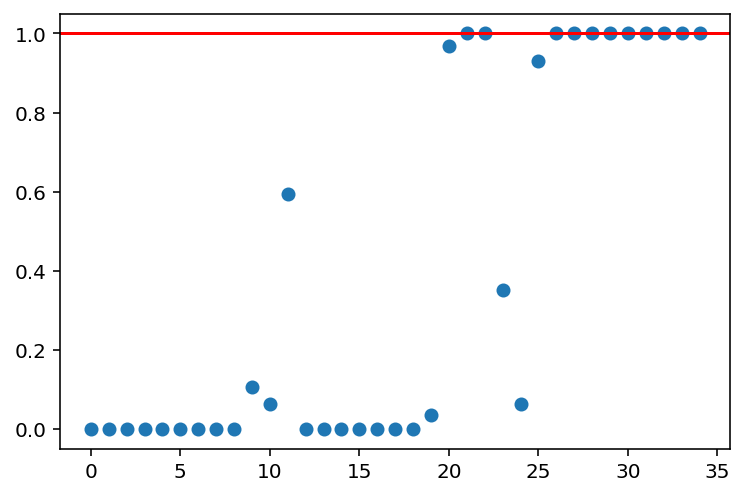

In [23]:
plt.scatter(range(len(z_ratio)), abs(np.array(z_ratio)))
plt.axhline(y = 1, color = 'r', linestyle = '-')

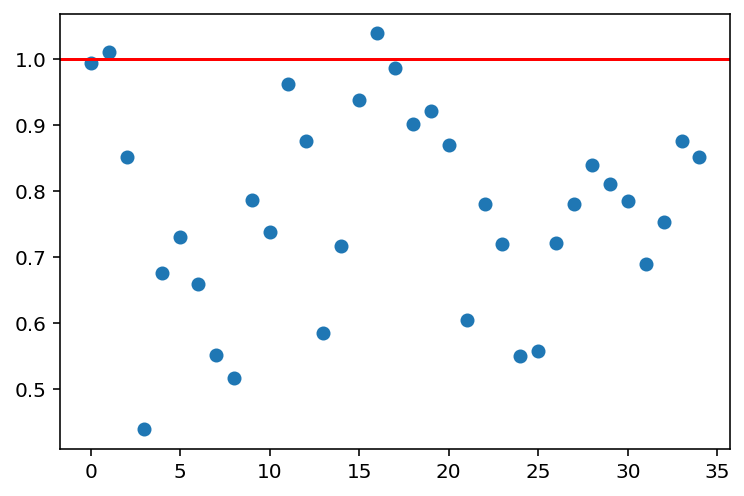

In [24]:
plt.scatter(range(len(b_ratio)), abs(np.array(b_ratio)))
plt.axhline(y = 1, color = 'r', linestyle = '-')

### Result analysis

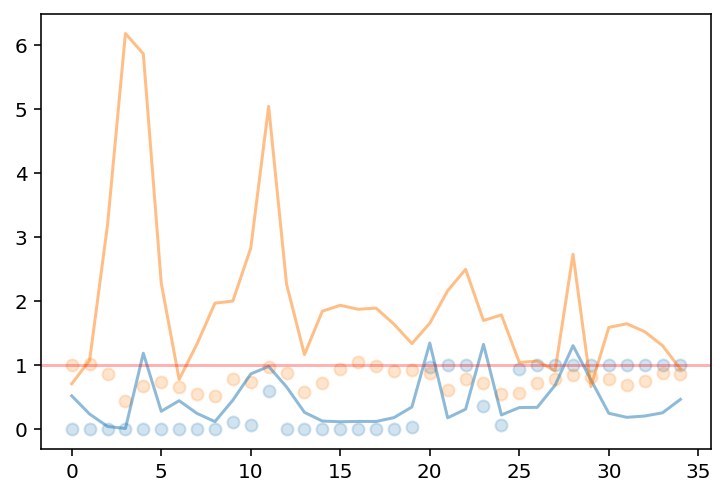

In [25]:
plt.plot(range(len(d_loss)), d_loss, alpha = 0.5);
plt.plot(range(len(g_loss)), g_loss, alpha = 0.5);
plt.scatter(range(len(z_ratio)), abs(np.array(z_ratio)), alpha = 0.2)
plt.scatter(range(len(b_ratio)), abs(np.array(b_ratio)), alpha = 0.2)
plt.axhline(y = 1, color = 'r', linestyle = '-', alpha = 0.3);

In [26]:
selected_method = GAN_at_minZ
z_dist_from_one = np.array([])
for i, val in enumerate(z_ratio):
    z_dist_from_one = np.append(z_dist_from_one, abs(val-1))
    if(i > num_epochs - save_model_back):
        print("Value: %f, Index: %d" %(abs(val-1),i))

In [27]:
selected_epoch_state = selected_method[3]
generator,discriminator = (selected_method[0], selected_method[1])
#generator,discriminator = GAN_at_epoch[selected_epoch_state%save_model_back]
generator.to(device)
discriminator.to(device)

#if(num_epochs - selected_epoch_state > save_model_back):
    #print("Error: model not saved at selected epoch!!! please choose later one.")

Discriminator(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (mp1): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=6144, out_features=6144, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Conv1d(32, 64, kernel_size=(32,), stride=(1,), padding=same)
  (mp2): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc2): Sequential(
    (0): Linear(in_features=12288, out_features=12288, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Conv1d(64, 256, kernel_size=(8,), stride=(1,), padding=same)
  (mp3): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc3): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
 

selected epoch: 34
selected epoch distance: 0.000000


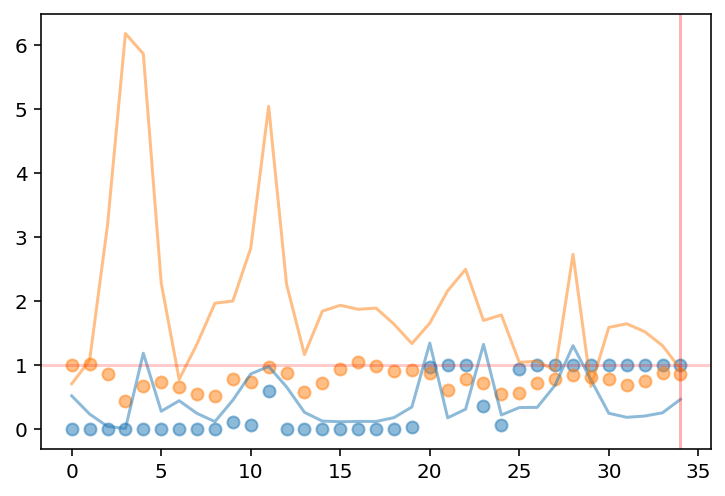

In [28]:
plt.plot(range(len(d_loss)), d_loss, alpha = 0.5);
plt.plot(range(len(g_loss)), g_loss, alpha = 0.5);
plt.scatter(range(len(z_ratio)), abs(np.array(z_ratio)), alpha = 0.5)
plt.scatter(range(len(b_ratio)), abs(np.array(b_ratio)), alpha = 0.5)
plt.axhline(y = 1, color = 'r', linestyle = '-', alpha = 0.2);
plt.axvline(x = selected_epoch_state, color = 'r', linestyle = '-', alpha = 0.3);
print("selected epoch: %d" %selected_epoch_state)
print("selected epoch distance: %f" %selected_method[2])

### Generate new file

Discriminator real data mean: 0.685


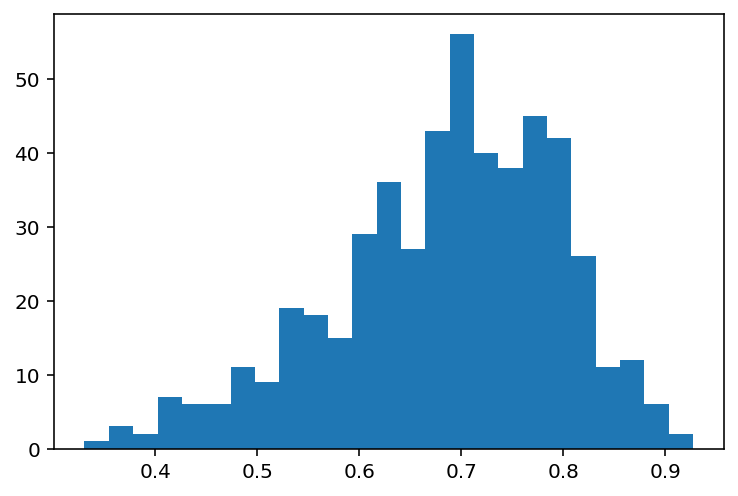

In [29]:
real_data_outputs = np.array([])
for real_samples, real_labels in train_loader:
    for real_song in real_samples:
        real_data_outputs = np.append(real_data_outputs, discriminator(real_song).detach().cpu().numpy())
print("Discriminator real data mean: %1.3f" %(real_data_outputs.mean()))
plt.hist(real_data_outputs, bins = 25);

In [30]:
generator_out = generator(seed).detach().cpu().numpy()
generator_out = scaler.inverse_transform(generator_out)
print(pd.DataFrame(generator_out.reshape(-1, num_features), columns = columns))
print(num_features)

          note      start  duration       diff  local_diff  is_piano  \
0    47.796574   2.484417 -1.789938  30.984020    0.114513 -0.004682   
1    50.213089  -0.855028  0.351911   9.560712    0.142253  0.127456   
2    44.213253  -2.284101  2.085759   2.229677    0.004420  0.015290   
3    49.138950   0.043804 -1.506576   1.182778    0.045860  0.072540   
4    53.117561  -0.081678 -2.682470  11.806472    0.107558  0.026629   
..         ...        ...       ...        ...         ...       ...   
187  39.244385  16.548733  0.890446  -9.238914    0.139822  0.072620   
188  56.368576  23.310879  0.458023  -4.015272   -0.058954  0.083840   
189  48.707558  20.794025  0.818392 -12.269819    0.121754  0.034121   
190  42.379520  24.878803  0.257782 -20.044027    0.150187  0.113536   
191  46.744675  19.181091 -0.120472   1.353558    0.070844  0.061719   

     is_organ  is_guitar   is_bass  is_strings  is_ensemble  is_brass  \
0    0.227735   0.058169 -0.039812    0.109151    -0.009446  0

### Use the model to generate a MIDI file

In [31]:
def createFile(name, bpm, notes, instrument = 0):
    mid = md.MidiFile()
    track = md.MidiTrack()
    mid.tracks.append(track)
    
    mytempo = md.bpm2tempo(bpm)
    track.append(md.MetaMessage('set_tempo', tempo=mytempo, time=0))
    track.append(md.Message('program_change', program=instrument, time=0))
    for i in range(len(notes) - 1):
        track.append(md.Message('note_on', note=notes[i], velocity=64, time=30))
        if(i > 0):
            track.append(md.Message('note_off', note=notes[i - 1], velocity=127, time=120))

    track.append(md.Message('note_off', note=notes[i], velocity=64, time=30))
    
    mid.save(name)

In [32]:
def diff2notes(diffs):
    notes = [diffs[0]] # the first diff is always the base note
    for i in range(1, len(diffs) -1, 1):
        notes.append(notes[i-1] + diffs[i])
    return notes

In [46]:
max_generated = [0] # dummy midi file, will be replaced by the best scored file.
max_score = -1
avg_score = 0
num_tries = 100 # take the best out of 100
for i in range(num_tries):
    generated = generator(torch.randn((1, seed_size)).to(device))
    score = discriminator(generated).data
    avg_score+= score
    if score > max_score:
        max_generated = generated
        max_score = score
print("best score: %f" %max_score)
print("avg score: %f" %(avg_score/num_tries))

# we have our new data, we can prepare to write it as midi file
generated = generated.detach().cpu().numpy()
generated = scaler.inverse_transform(generated)
gan_result = pd.DataFrame(generated.reshape(-1, num_features), columns = columns)
if("diff" in columns):
    result_diffs = []
    for note in gan_result["diff"]:
        result_diffs.append(round(note))
    notes_from_diff = diff2notes(result_diffs)
    print(notes_from_diff)

if("note" in columns):
    result_notes = []
    for note in gan_result["note"]:
        result_notes.append(round(note))

gan_result

best score: 0.534745
avg score: 0.463078
[31, 41, 43, 44, 56, 64, 60, 47, 41, 42, 30, 31, 25, 22, 17, 21, 21, 17, 18, 3, -3, 8, 7, -2, -15, -31, -43, -61, -80, -92, -119, -138, -151, -164, -177, -186, -207, -219, -232, -229, -238, -247, -254, -256, -262, -263, -266, -268, -282, -287, -298, -313, -319, -335, -343, -353, -371, -380, -389, -406, -425, -439, -442, -449, -463, -473, -482, -493, -504, -512, -526, -531, -537, -543, -542, -547, -557, -564, -576, -580, -593, -605, -615, -636, -646, -651, -667, -674, -684, -692, -718, -734, -747, -759, -767, -773, -780, -792, -802, -812, -829, -838, -844, -855, -861, -882, -902, -913, -923, -931, -936, -937, -944, -935, -933, -937, -934, -942, -940, -940, -941, -947, -957, -964, -969, -975, -981, -989, -980, -989, -999, -1005, -1021, -1032, -1036, -1043, -1046, -1054, -1063, -1057, -1079, -1092, -1091, -1094, -1109, -1123, -1136, -1144, -1152, -1163, -1182, -1201, -1213, -1230, -1234, -1239, -1249, -1252, -1268, -1275, -1281, -1298, -1310, -1323

,note,start,duration,diff,local_diff,is_piano,is_organ,is_guitar,is_bass,is_strings,is_ensemble,is_brass,is_reed,is_pipe,is_synth_lead,is_synth_pad
0,47.792316,2.494701,-1.789067,30.954351,0.114522,-0.004675,0.227608,0.058149,-0.039660,0.109157,-0.009388,0.036409,0.117824,0.094939,-0.023170,45.179573
1,50.202236,-0.853236,0.351378,9.538358,0.142292,0.127465,0.064180,0.012354,0.022657,0.049458,-0.054453,-0.065642,-0.001181,0.058163,0.059799,-11.649716
2,44.207706,-2.281981,2.083986,2.216247,0.004470,0.015375,0.139878,0.024673,0.058853,0.109754,0.024167,-0.066295,-0.035203,-0.099840,-0.045900,-12.122161
3,49.120991,0.039953,-1.505477,1.173767,0.045923,0.072518,0.199801,0.047637,0.083994,0.061179,0.085140,-0.043242,-0.057795,-0.005609,0.008188,-16.867159
4,53.107967,-0.082246,-2.677516,11.778035,0.107593,0.026592,0.131062,0.077876,0.149956,0.064009,0.108818,0.007260,-0.063097,-0.056279,0.029605,-13.747616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,39.234730,16.540123,0.890276,-9.250990,0.139868,0.072611,0.215536,0.104527,0.024615,-0.090861,0.000754,0.032019,0.019553,0.064227,-0.047026,-18.228443
188,56.367142,23.317492,0.458142,-4.020473,-0.058948,0.083892,0.171160,0.064945,0.071200,0.088683,0.035155,0.028257,0.087016,0.088167,-0.029875,-15.352912
189,48.703388,20.788418,0.818126,-12.293962,0.121784,0.034112,0.181068,0.164748,0.080874,-0.018492,0.028092,-0.007553,0.081214,-0.020588,0.009623,-25.577539
190,42.377441,24.882206,0.257816,-20.045958,0.150191,0.113575,0.203947,0.033774,0.001015,0.044015,0.054395,0.008609,0.012043,0.007717,0.016314,-9.458370


In [47]:
try_trace_diff = False
if("diff" in columns and try_trace_diff):
    result_notes_filtered = []
    for note in notes_from_diff:
      if note > 126 or note < 1:
        print("Warning: Integrity issue: %d" %note)
      else:
        result_notes_filtered.append(note)

    if len(result_notes_filtered) > 1:
      createFile("/content/drive/MyDrive/GAN out/GAN output diffs.mid", 100, result_notes_filtered)
      plt.scatter(range(len(result_notes_filtered)), result_notes_filtered)

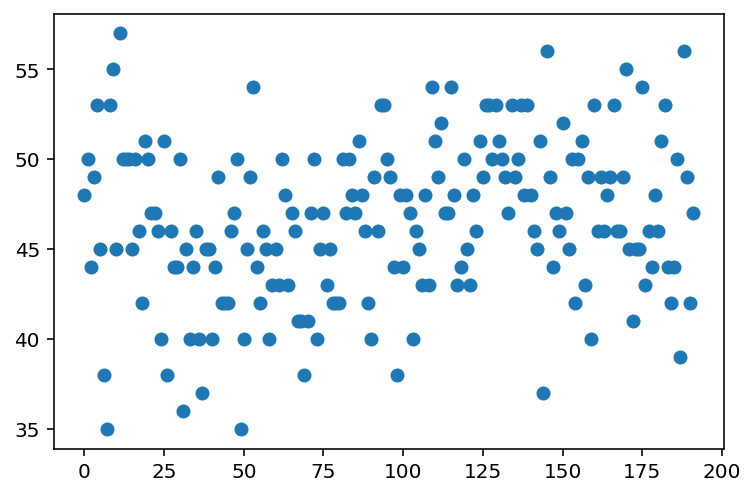

In [48]:
if("note" in columns):
    result_notes_filtered = []
    for note in result_notes:
      if note > 126 or note < 1:
        print("Warning: Integrity issue: %d" %note)
      else:
        result_notes_filtered.append(note)

    if len(result_notes_filtered) > 1:
        createFile("/content/drive/MyDrive/GAN out/GAN output notes.mid", 100, result_notes_filtered)
        plt.scatter(range(len(result_notes_filtered)), result_notes_filtered)

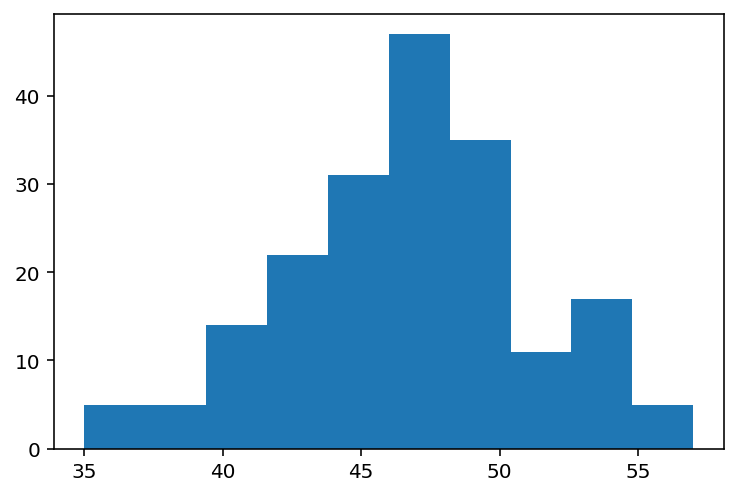

In [49]:
plt.hist(result_notes_filtered);

In [50]:
if "start" in columns:
    gan_result_sorted_by_start = gan_result.sort_values(by=['start'], ignore_index=True).reset_index(drop=True)
    result_notes = gan_result_sorted_by_start["note"]
    if("note" in columns):
        result_notes_filtered = []
        for note in result_notes:
          if note > 126 or note < 1:
            print("Warning: Integrity issue: %d" %note)
          else:
            result_notes_filtered.append(round(note))
            
        if len(result_notes_filtered) > 1:
            createFile("/content/drive/MyDrive/GAN out/GAN output notes by start.mid", 100, result_notes_filtered)

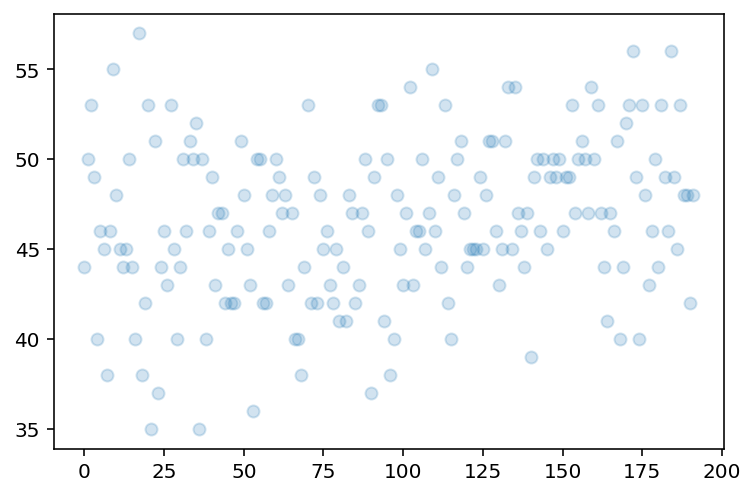

In [51]:
plt.scatter(range(len(result_notes_filtered)), result_notes_filtered, alpha = 0.2); # sorted by time

In [52]:
gan_result

,note,start,duration,diff,local_diff,is_piano,is_organ,is_guitar,is_bass,is_strings,is_ensemble,is_brass,is_reed,is_pipe,is_synth_lead,is_synth_pad
0,47.792316,2.494701,-1.789067,30.954351,0.114522,-0.004675,0.227608,0.058149,-0.039660,0.109157,-0.009388,0.036409,0.117824,0.094939,-0.023170,45.179573
1,50.202236,-0.853236,0.351378,9.538358,0.142292,0.127465,0.064180,0.012354,0.022657,0.049458,-0.054453,-0.065642,-0.001181,0.058163,0.059799,-11.649716
2,44.207706,-2.281981,2.083986,2.216247,0.004470,0.015375,0.139878,0.024673,0.058853,0.109754,0.024167,-0.066295,-0.035203,-0.099840,-0.045900,-12.122161
3,49.120991,0.039953,-1.505477,1.173767,0.045923,0.072518,0.199801,0.047637,0.083994,0.061179,0.085140,-0.043242,-0.057795,-0.005609,0.008188,-16.867159
4,53.107967,-0.082246,-2.677516,11.778035,0.107593,0.026592,0.131062,0.077876,0.149956,0.064009,0.108818,0.007260,-0.063097,-0.056279,0.029605,-13.747616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,39.234730,16.540123,0.890276,-9.250990,0.139868,0.072611,0.215536,0.104527,0.024615,-0.090861,0.000754,0.032019,0.019553,0.064227,-0.047026,-18.228443
188,56.367142,23.317492,0.458142,-4.020473,-0.058948,0.083892,0.171160,0.064945,0.071200,0.088683,0.035155,0.028257,0.087016,0.088167,-0.029875,-15.352912
189,48.703388,20.788418,0.818126,-12.293962,0.121784,0.034112,0.181068,0.164748,0.080874,-0.018492,0.028092,-0.007553,0.081214,-0.020588,0.009623,-25.577539
190,42.377441,24.882206,0.257816,-20.045958,0.150191,0.113575,0.203947,0.033774,0.001015,0.044015,0.054395,0.008609,0.012043,0.007717,0.016314,-9.458370


In [53]:
from numpy.ma.core import remainder
quantize_measure = 0.125 # 1/16 for 120bpm
scaleA_notes = [0, 2, 4, 5, 7, 9, 11]
finalized_notes = []
def pandasToMIDI(df_input, instrument = 0, filename = "/content/drive/MyDrive/GAN out/gan midi with times.mid", round_digits = 5, quantize = False, soft_fix_notes = False, transpose_by = 0):
    midi_file = pretty_midi.PrettyMIDI()
    midi_channel = pretty_midi.Instrument(program=instrument)
    min_time = round(min(abs(df_input["start"])), round_digits)
    if(min_time < 0):
        min_time*=-1
    else:
        min_time = 0
    for row in df_input.iterrows():

        # ensure duration is valid
        duration = round(row[1]["duration"], round_digits)
        if(duration < 0):
            duration *=-1
        if(duration > 10):
            duration = 10
        start = -min_time + abs(round(row[1]["start"], round_digits))

        # quantize start times
        if(quantize):
              div = int(start/quantize_measure)
              mod = start/quantize_measure - int(start/quantize_measure)
              start = start - mod * quantize_measure

        # soft-move notes to scale
        if(round(row[1]["note"]) < 1 or round(row[1]["note"]) > 127):
            print("Warning: Integrity issue: %d" %round(row[1]["note"]))
        cur_note = round(row[1]["note"])
        remainder = row[1]["note"] - cur_note
        if(soft_fix_notes):
            # if the current note is not in-scale, but rounded up/down is - convert it. Otherwise - leave note as is.
            if(remainder >= 0.5 and not cur_note%12 in scaleA_notes and (cur_note + 1)%12 in scaleA_notes):
                cur_note = cur_note + 1
            if(remainder < 0.5 and not cur_note%12 in scaleA_notes and (cur_note - 1)%12 in scaleA_notes):
                cur_note = cur_note - 1

        cur_note = cur_note + transpose_by
        if(cur_note >= 0 and cur_note <= 127):
            finalized_notes.append(cur_note)
            note = pretty_midi.Note(velocity=80, pitch=cur_note, start=start, end=start + duration)
            midi_channel.notes.append(note)
            
    midi_file.instruments.append(midi_channel)
    midi_file.write(filename)
    print("File created: %s" %filename)
    return finalized_notes

In [54]:
from random import randrange
start_time_filtered_df = gan_result[gan_result["start"] >= 0]
duration_filtered_df = start_time_filtered_df[start_time_filtered_df["duration"] > 0]
print("Percentage of valid notes: %f" %(len(duration_filtered_df)/comp_length))
written_notes = pandasToMIDI(duration_filtered_df, round_digits=3, quantize = True, soft_fix_notes = True, transpose_by= randrange(12,24))

Percentage of valid notes: 0.817708
File created: /content/drive/MyDrive/GAN out/gan midi with times.mid


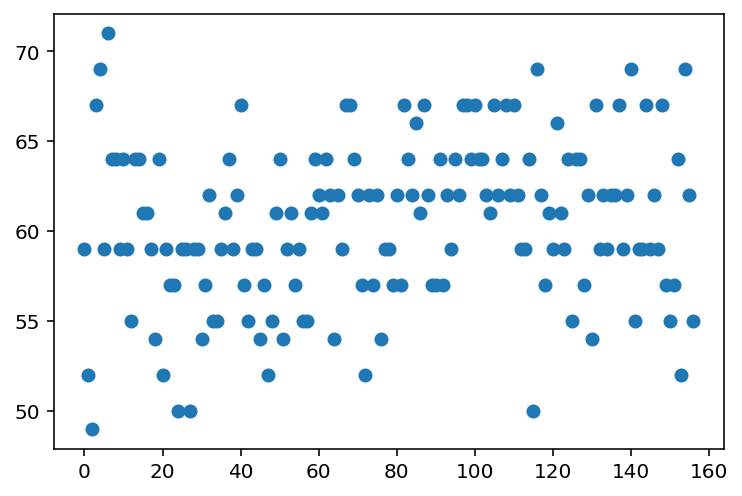

In [55]:
plt.scatter(range(len(written_notes)), written_notes);

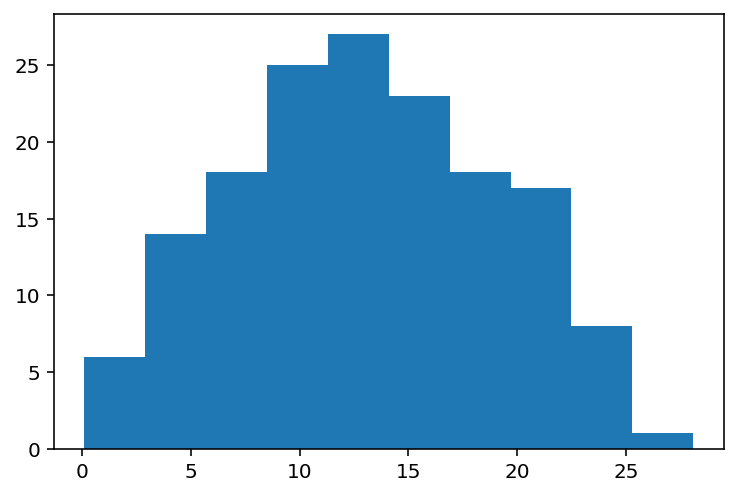

In [56]:
plt.hist(duration_filtered_df["start"]);

In [57]:
save_model = True
save_filename = "/content/drive/MyDrive/Data Science project/GAN_saved_state.pickle"
if(save_model):
    pickle.dump((selected_method,scaler) , open(save_filename, "wb"))
    print("saved model in file: " + save_filename)
    GAN_from_disk, scaler = pickle.load(open(save_filename, "rb"))
    print(GAN_from_disk)
    print(scaler)

saved model in file: /content/drive/MyDrive/Data Science project/GAN_saved_state.pickle
(Generator(
  (fc1): Sequential(
    (0): Linear(in_features=192, out_features=384, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=384, out_features=768, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=768, out_features=3072, bias=True)
  )
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (fc2): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=3072, out_features=3072, bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=3072, out_features=3072, bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=3072, out_features=3072, bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Lin

In [58]:
duration_filtered_df

,note,start,duration,diff,local_diff,is_piano,is_organ,is_guitar,is_bass,is_strings,is_ensemble,is_brass,is_reed,is_pipe,is_synth_lead,is_synth_pad
5,44.861984,1.550800,0.411042,7.859567,0.080720,0.116091,0.116298,0.034836,0.086220,0.026595,0.081991,-0.004810,0.024725,-0.002629,0.003670,-15.121583
6,38.452599,1.948465,0.761504,-4.379311,0.145088,0.020425,0.235905,-0.071721,0.015073,0.089179,0.007375,-0.039164,0.015276,-0.014497,0.011210,-19.138924
7,35.451302,6.372596,1.010975,-13.293365,0.158877,0.079525,0.177655,0.046233,0.010464,0.074540,0.045208,-0.060985,-0.008908,0.035476,0.038924,-10.090768
8,52.550621,5.269499,2.012756,-5.967803,0.039312,0.000268,0.235894,0.047470,-0.007287,0.014778,0.042620,-0.017037,0.023910,0.147004,0.049126,-9.905525
9,55.451691,2.195638,1.363449,1.099771,0.115208,0.011922,0.225007,0.031728,-0.026753,0.047780,-0.063979,0.042512,0.081752,-0.034053,0.060580,-7.894073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,49.993076,12.826685,0.752197,-12.756922,0.069723,0.066276,0.279175,0.078382,-0.048079,-0.072580,0.010799,0.095676,0.004287,0.024666,0.085093,-15.116080
187,39.234730,16.540123,0.890276,-9.250990,0.139868,0.072611,0.215536,0.104527,0.024615,-0.090861,0.000754,0.032019,0.019553,0.064227,-0.047026,-18.228443
188,56.367142,23.317492,0.458142,-4.020473,-0.058948,0.083892,0.171160,0.064945,0.071200,0.088683,0.035155,0.028257,0.087016,0.088167,-0.029875,-15.352912
189,48.703388,20.788418,0.818126,-12.293962,0.121784,0.034112,0.181068,0.164748,0.080874,-0.018492,0.028092,-0.007553,0.081214,-0.020588,0.009623,-25.577539
